In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import mglearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [2]:
fN = '/Users/anaso/Documents/AA/AA-22-23/Trabalho Final/imdbFull.p'

D = pickle.load(open(fN, 'rb'))

In [3]:
print(D.keys())

dict_keys(['data', 'target', 'DESCR'])


Tamanho do corpus:  5000
Classes:  [ 1  2  3  4  7  8  9 10]


<BarContainer object of 10 artists>

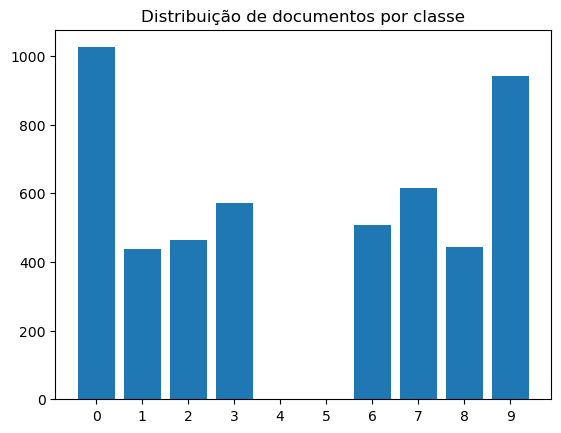

In [4]:
nDocs = 5000

corpus = D.data[:nDocs]
y = D.target[:nDocs]

print("Tamanho do corpus: ", len(corpus))
print("Classes: ", np.unique(y))

plt.figure()
plt.title("Distribuição de documentos por classe")
labels = [str(val) for val in np.arange(10)]
sizes, _ = np.histogram(y)
plt.bar(labels, sizes)



## Limpeza dos dados

In [5]:
corpus = [critica.replace("<br />", " ") for critica in corpus]
corpus = [" ".join((palavra if palavra not in stop_words else " ") for palavra in critica.split()) for critica in corpus]
corpus = [" ".join(lemma.lemmatize(palavra) for palavra in critica.split()) for critica in corpus]

In [6]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, shuffle=True, stratify=y, test_size=1/3) 
corpus_train, corpus_validacao, y_train, y_validacao = train_test_split(corpus_train, y_train, shuffle=True, stratify=y_train, test_size=1/2)

In [7]:
print("Tamanho do conjunto de treino: ", len(corpus_train))
print("Tamanho do conjunto de validação: ", len(corpus_validacao))
print("Tamanho do conjunto de teste: ", len(corpus_test))

Tamanho do conjunto de treino:  1666
Tamanho do conjunto de validação:  1667
Tamanho do conjunto de teste:  1667


## TFIDF sem parametros

In [28]:
tf = TfidfVectorizer().fit(corpus_train)

dicionario_tf_default = len(tf.get_feature_names_out())

corpus_train_p = tf.transform(corpus_train)
corpus_test_p = tf.transform(corpus_test)


## LogisiticRegression sem parametros

In [29]:
lr = LogisticRegression(max_iter=10000).fit(corpus_train_p, y_train)

## Avaliação

In [30]:
print("Score Treino: ", np.round(lr.score(corpus_train_p, y_train), 3))
print("Score Teste: ", np.round(lr.score(corpus_test_p, y_test), 3))

Score Treino:  0.87
Score Teste:  0.362


# Validação de parametros TfidfVectorizer

In [12]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10000))

param_grid = [{'tfidfvectorizer__min_df': [1, 2, 3, 4, 5], 
              'tfidfvectorizer__max_df': [0.95, 0.85, 0.75, 0.65, 0.55]},  
             
             {'tfidfvectorizer__ngram_range': [(1,1), (1,2), (2,2), (1, 3), (2,3), (3,3)], 
              'logisticregression__C': [0.01, 0.1, 1, 10, 100]}, 
             
             {'tfidfvectorizer__token_pattern': [r'(\S+)', r'\b[a-zA-Z]{3,}\b', r'\b\w{3,}\b'], 
              'logisticregression__C': [0.01, 0.1, 1, 10, 100]}]

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=3)
grid.fit(corpus_validacao, y_validacao)

print("Best parameters: ", grid.best_params_)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV 1/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.360 total time=   1.1s
[CV 2/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.363 total time=   1.0s
[CV 3/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=1;, score=0.369 total time=   1.1s
[CV 1/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=2;, score=0.371 total time=   0.6s
[CV 2/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=2;, score=0.371 total time=   0.5s
[CV 3/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=2;, score=0.368 total time=   0.5s
[CV 1/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=3;, score=0.365 total time=   0.4s
[CV 2/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=3;, score=0.365 total time=   0.5s
[CV 3/3] END tfidfvectorizer__max_df=0.95, tfidfvectorizer__min_df=3;, score=0.360 total time=   0.4s
[CV 1/3] END tfidfve

[CV 3/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(1, 2);, score=0.205 total time=   3.1s
[CV 1/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(2, 2);, score=0.205 total time=   2.4s
[CV 2/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(2, 2);, score=0.205 total time=   2.3s
[CV 3/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(2, 2);, score=0.205 total time=   2.5s
[CV 1/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(1, 3);, score=0.205 total time=   5.7s
[CV 2/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(1, 3);, score=0.205 total time=   6.3s
[CV 3/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(1, 3);, score=0.205 total time=   5.9s
[CV 1/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(2, 3);, score=0.205 total time=   4.9s
[CV 2/3] END logisticregression__C=0.01, tfidfvectorizer__ngram_range=(2, 3);, score=0.205 total time=   5.4s
[CV 3/3] E

[CV 1/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(1, 3);, score=0.371 total time=  43.5s
[CV 2/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(1, 3);, score=0.362 total time=  41.3s
[CV 3/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(1, 3);, score=0.386 total time=  40.1s
[CV 1/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(2, 3);, score=0.300 total time=  29.9s
[CV 2/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(2, 3);, score=0.297 total time=  34.2s
[CV 3/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(2, 3);, score=0.310 total time=  26.8s
[CV 1/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(3, 3);, score=0.248 total time=  13.1s
[CV 2/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(3, 3);, score=0.239 total time=  17.0s
[CV 3/3] END logisticregression__C=100, tfidfvectorizer__ngram_range=(3, 3);, score=0.247 total time=  16.4s
[CV 1/3] END logist

## Análise dos parametros min_df e max_dt do TfidfVectorizer

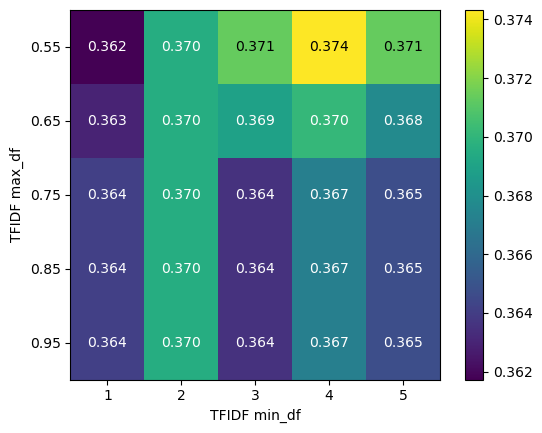

In [13]:
scores = grid.cv_results_['mean_test_score'][:25].reshape(-1, 5)
heatmap = mglearn.tools.heatmap(
    scores, ylabel="TFIDF max_df", xlabel="TFIDF min_df", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid[0]["tfidfvectorizer__min_df"], 
    yticklabels=param_grid[0]["tfidfvectorizer__max_df"]
)
plt.colorbar(heatmap)

## Análise do parametro ngram_range do TfidfVectorizer

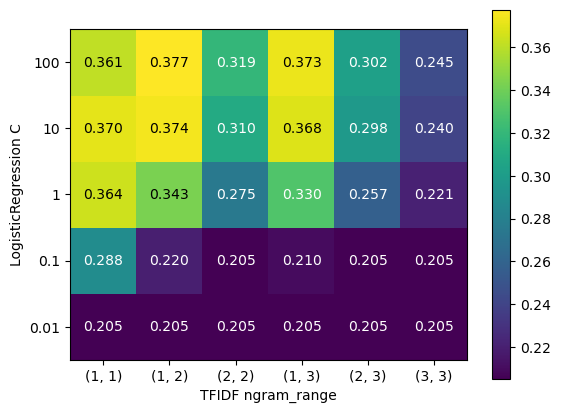

In [14]:
scores = grid.cv_results_['mean_test_score'][25:55].reshape(-1, 6)
heatmap = mglearn.tools.heatmap(
    scores, xlabel="TFIDF ngram_range", ylabel="LogisticRegression C", cmap="viridis", fmt="%.3f", 
    yticklabels=param_grid[1]["logisticregression__C"], 
    xticklabels=param_grid[1]["tfidfvectorizer__ngram_range"]
)
plt.colorbar(heatmap)

## Análise do parametro token_pattern do TfidfVectorizer

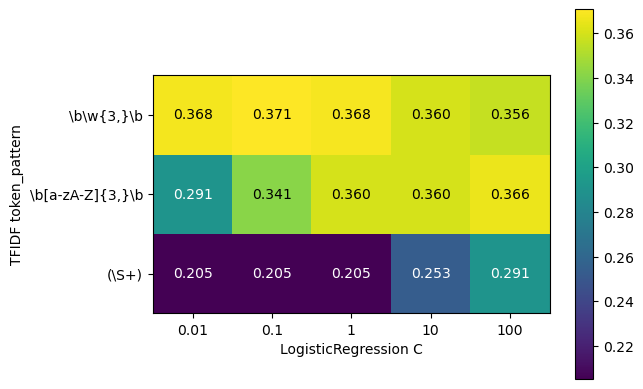

In [15]:
scores = grid.cv_results_['mean_test_score'][55:].reshape(-1, 5)
heatmap = mglearn.tools.heatmap(
    scores, ylabel="TFIDF token_pattern", xlabel="LogisticRegression C", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid[2]["logisticregression__C"], 
    yticklabels=param_grid[2]["tfidfvectorizer__token_pattern"]
)
plt.colorbar(heatmap)

## Análise filtrada com os melhores parametros encontrados acima

In [16]:
pipe = make_pipeline(TfidfVectorizer(token_pattern=r'\b\w{3,}\b'), LogisticRegression(max_iter=10000))

param_grid = {'tfidfvectorizer__min_df': [3, 4, 5], 
             'tfidfvectorizer__max_df': [0.75, 0.65, 0.55],
             'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)],
              'logisticregression__C': [0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3)
grid.fit(corpus_validacao, y_validacao)

print("Best parameters: ", grid.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.320 total time=   0.2s
[CV 2/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.332 total time=   0.4s
[CV 3/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.297 total time=   0.4s
[CV 4/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.312 total time=   0.3s
[CV 5/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.324 total time=   0.3s
[CV 1/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=3, tfidfvecto

[CV 5/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.324 total time=   0.3s
[CV 1/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.299 total time=   0.9s
[CV 2/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.320 total time=   0.7s
[CV 3/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.294 total time=   0.6s
[CV 4/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.300 total time=   0.8s
[CV 5/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.318 total time=   0.7s
[CV 

[CV 5/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.318 total time=   0.7s
[CV 1/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 3);, score=0.302 total time=   1.0s
[CV 2/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 3);, score=0.320 total time=   0.9s
[CV 3/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 3);, score=0.291 total time=   0.9s
[CV 4/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 3);, score=0.312 total time=   0.8s
[CV 5/5] END logisticregression__C=0.1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 3);, score=0.318 total time=   1.0s
[CV 

[CV 5/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 3);, score=0.372 total time=   1.2s
[CV 1/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 1);, score=0.356 total time=   0.5s
[CV 2/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 1);, score=0.383 total time=   0.5s
[CV 3/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 1);, score=0.369 total time=   0.4s
[CV 4/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 1);, score=0.363 total time=   0.4s
[CV 5/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 1);, score=0.363 total time=   0.5s
[CV 1/5] END log

[CV 5/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 1);, score=0.375 total time=   0.4s
[CV 1/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 2);, score=0.359 total time=   1.0s
[CV 2/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 2);, score=0.389 total time=   0.8s
[CV 3/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 2);, score=0.357 total time=   0.8s
[CV 4/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 2);, score=0.381 total time=   0.9s
[CV 5/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 2);, score=0.378 total time=   0.9s
[CV 1/5] END log

[CV 5/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 2);, score=0.384 total time=   0.8s
[CV 1/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 3);, score=0.365 total time=   1.0s
[CV 2/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 3);, score=0.377 total time=   0.9s
[CV 3/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 3);, score=0.360 total time=   1.1s
[CV 4/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 3);, score=0.381 total time=   1.0s
[CV 5/5] END logisticregression__C=1, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 3);, score=0.387 total time=   1.1s
[CV 1/5] END log

[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=4, tfidfvectorizer__ngram_range=(1, 3);, score=0.408 total time=   1.7s
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 1);, score=0.326 total time=   0.9s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 1);, score=0.386 total time=   0.8s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 1);, score=0.339 total time=   0.8s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 1);, score=0.396 total time=   0.8s
[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 1);, score=0.417 total time=   0.8s
[CV 1/5] E

[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 1);, score=0.405 total time=   0.7s
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2);, score=0.326 total time=   1.2s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2);, score=0.380 total time=   1.2s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2);, score=0.342 total time=   1.0s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2);, score=0.411 total time=   1.4s
[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2);, score=0.411 total time=   1.3s
[CV 1/5] E

[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2);, score=0.417 total time=   1.0s
[CV 1/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 3);, score=0.317 total time=   1.2s
[CV 2/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 3);, score=0.374 total time=   1.5s
[CV 3/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 3);, score=0.339 total time=   1.4s
[CV 4/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 3);, score=0.405 total time=   1.4s
[CV 5/5] END logisticregression__C=10, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 3);, score=0.417 total time=   1.3s
[CV 1/5] E

[CV 5/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.75, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 3);, score=0.399 total time=   1.9s
[CV 1/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.302 total time=   1.5s
[CV 2/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.374 total time=   1.6s
[CV 3/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.336 total time=   1.7s
[CV 4/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.363 total time=   1.6s
[CV 5/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.65, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.393 total time=   1.6s
[CV 

[CV 5/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.390 total time=   1.5s
[CV 1/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.332 total time=   2.7s
[CV 2/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.374 total time=   2.6s
[CV 3/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.345 total time=   2.6s
[CV 4/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.405 total time=   2.3s
[CV 5/5] END logisticregression__C=100, tfidfvectorizer__max_df=0.55, tfidfvectorizer__min_df=3, tfidfvectorizer__ngram_range=(1, 2);, score=0.420 total time=   3.4s
[CV 

In [17]:
# corpus de treino e validação
corpus_treino_validacao = np.hstack((corpus_train, corpus_validacao))
y_treino_validacao = np.hstack((y_train, y_validacao))


In [18]:
tf = TfidfVectorizer(min_df=3, max_df=0.75, ngram_range=(1,3), token_pattern=r'\b\w{3,}\b').fit(corpus_treino_validacao) 


corpus_treino_validacao_p = tf.transform(corpus_treino_validacao)
corpus_test_p = tf.transform(corpus_test)

In [19]:
lr = LogisticRegression(max_iter=10000, C = 10).fit(corpus_treino_validacao_p, y_treino_validacao)

print("Treino: ", lr.score(corpus_treino_validacao_p, y_treino_validacao))
print("Teste: ", lr.score(corpus_test_p, y_test))

Treino:  1.0
Teste:  0.39472105578884226


In [20]:
y_treino_e = lr.predict(corpus_treino_validacao_p)
y_teste_e = lr.predict(corpus_test_p)

## Resultados Treino

Número de erros:  0
Accuracy:  1.0
[ 1  2  3  4  7  8  9 10]


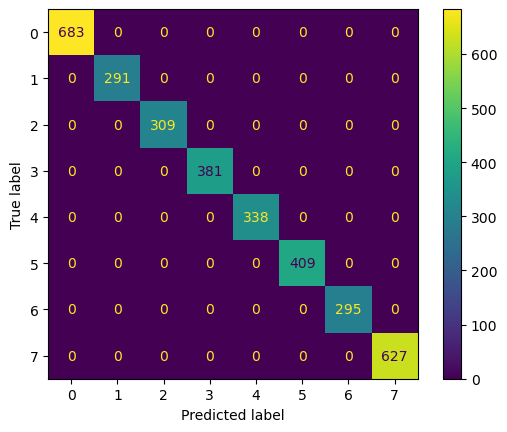

In [21]:
print("Número de erros: ", np.sum(y_treino_validacao != y_treino_e))
print("Accuracy: ", accuracy_score(y_treino_validacao, y_treino_e))
matriz_confusao = confusion_matrix(y_treino_validacao, y_treino_e)

disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()

print(np.unique(y_treino_validacao))


## Resultados Teste

Número de erros:  1009
Accuracy:  0.39472105578884226


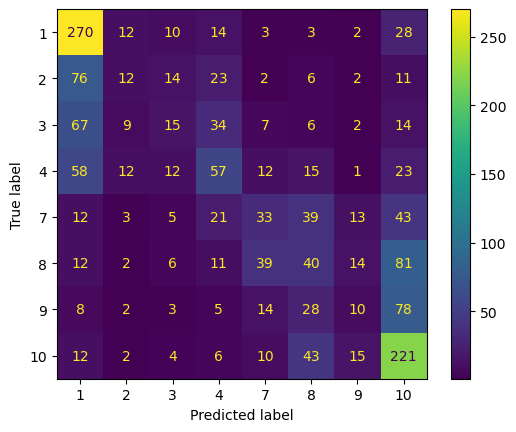

In [22]:
print("Número de erros: ", np.sum(y_test != y_teste_e))
print("Accuracy: ", accuracy_score(y_test, y_teste_e))
matriz_confusao = confusion_matrix(y_test, y_teste_e)

disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=np.unique(y_test))
disp.plot()
plt.show()

## Análise do parametro max_features do TfidfVectorizer

In [23]:
pipe = make_pipeline(TfidfVectorizer(min_df=3, max_df=0.75, ngram_range=(1,3), token_pattern=r'\b\w{3,}\b'), LogisticRegression(max_iter=10000))

param_grid = {'tfidfvectorizer__max_features': [10000, 5000, 3000, 2000, 1000, 500, 300],
              'logisticregression__C': [0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid, cv=3, verbose=3)
grid.fit(corpus_validacao, y_validacao)

print("Best parameters: ", grid.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV 1/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=10000;, score=0.286 total time=   1.3s
[CV 2/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=10000;, score=0.281 total time=   1.2s
[CV 3/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=10000;, score=0.312 total time=   1.5s
[CV 1/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.318 total time=   1.2s
[CV 2/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.295 total time=   1.2s
[CV 3/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=5000;, score=0.319 total time=   1.2s
[CV 1/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=3000;, score=0.322 total time=   1.3s
[CV 2/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=3000;, score=0.302 total time=   1.3s
[CV 3/3] END logisticregression__C=0.1, tfidfvectorizer__max_features=30

[CV 2/3] END logisticregression__C=100, tfidfvectorizer__max_features=1000;, score=0.324 total time=   1.5s
[CV 3/3] END logisticregression__C=100, tfidfvectorizer__max_features=1000;, score=0.317 total time=   1.3s
[CV 1/3] END logisticregression__C=100, tfidfvectorizer__max_features=500;, score=0.302 total time=   1.4s
[CV 2/3] END logisticregression__C=100, tfidfvectorizer__max_features=500;, score=0.308 total time=   1.3s
[CV 3/3] END logisticregression__C=100, tfidfvectorizer__max_features=500;, score=0.285 total time=   1.4s
[CV 1/3] END logisticregression__C=100, tfidfvectorizer__max_features=300;, score=0.297 total time=   1.5s
[CV 2/3] END logisticregression__C=100, tfidfvectorizer__max_features=300;, score=0.282 total time=   1.3s
[CV 3/3] END logisticregression__C=100, tfidfvectorizer__max_features=300;, score=0.254 total time=   1.3s
Best parameters:  {'logisticregression__C': 1, 'tfidfvectorizer__max_features': 3000}


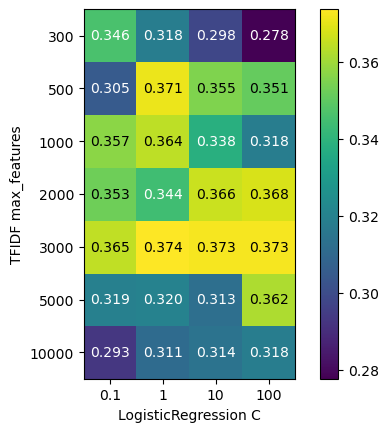

In [24]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 4)
heatmap = mglearn.tools.heatmap(
    scores, xlabel="LogisticRegression C", ylabel="TFIDF max_features", cmap="viridis", fmt="%.3f", 
    yticklabels=param_grid["tfidfvectorizer__max_features"], 
    xticklabels=param_grid["logisticregression__C"]
)
plt.colorbar(heatmap)

## Análise ao tamanho do vocabulário

In [25]:
tf_default = TfidfVectorizer().fit(corpus)
tf_parametrizado = TfidfVectorizer(min_df=3, max_df=0.75, ngram_range=(1,3), token_pattern=r'\b\w{3,}\b').fit(corpus)

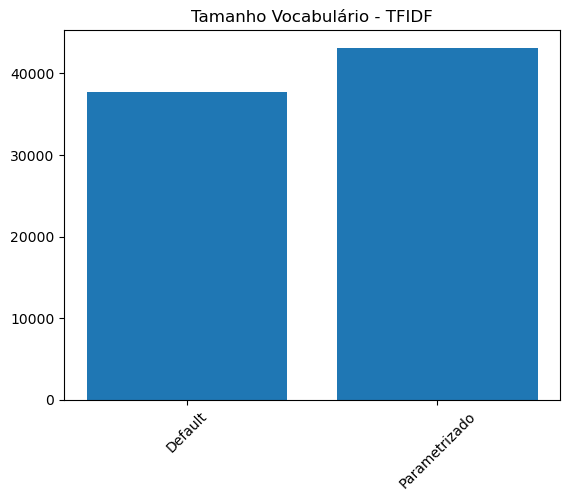

Tamanho vocabulário Default : 37687
Tamanho vocabulário Parametrizado : 43159


In [26]:
dicionarios = ['Default', 'Parametrizado']
tamanhos = [len(tf_default.get_feature_names_out()), len(tf_parametrizado.get_feature_names_out())]

plt.figure()
plt.title("Tamanho Vocabulário - TFIDF")
plt.bar(dicionarios, tamanhos)
plt.xticks(rotation = 45)
plt.show()

for i in range(len(dicionarios)): 
    print("Tamanho vocabulário", dicionarios[i], ':', tamanhos[i])

In [31]:
corpus_train_p = tf_parametrizado.transform(corpus_train)
corpus_test_p = tf_parametrizado.transform(corpus_test)

lr = LogisticRegression(max_iter=10000).fit(corpus_train_p, y_train)
print("Score Treino: ", np.round(lr.score(corpus_train_p, y_train), 3))
print("Score Teste: ", np.round(lr.score(corpus_test_p, y_test), 3))

Score Treino:  0.894
Score Teste:  0.36
